ДЗ Резников Никита ТФэ-01-21

Построить `график` зависимости термического КПД от давления промежуточного перегрева водяного пара для условий примера: $Р_0$=12 МПа; $t_0$=530 °С; $Р_к$=5 кПа. Параметры промперегрева: $Р_{п.п.}$=1, 2, 3, 4, 5, 6 МПа; $t_{п.п.}$=530 °С.

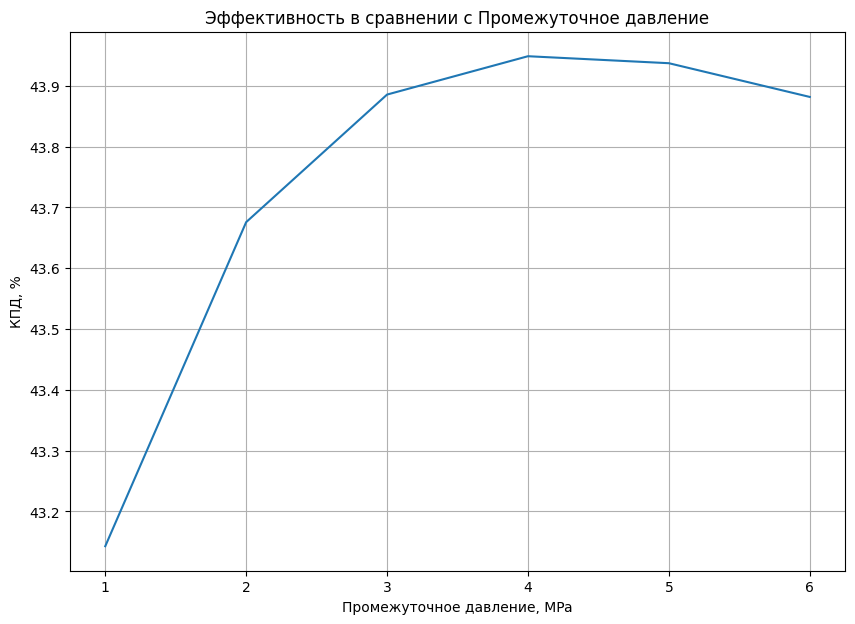

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from iapws import IAPWS97 as gas

MPa = 10 ** 6
kPa = 10 ** 3
unit = 1 / MPa
grad_Cels = 1

initial_pressure = 12 * MPa
condenser_pressure = 5 * kPa
initial_temperature = 450 * grad_Cels
intermediate_pressures = np.array([1, 2, 3, 4, 5, 6])
intermediate_temperature = 530 * grad_Cels

fig, graph = plt.subplots(1, 1, figsize=(10, 7))
efficiency_values = []

for intermediate_pressure_value in intermediate_pressures:
    state_1 = gas(P=initial_pressure * unit, T=(initial_temperature + 273.15))
    state_2 = gas(P=intermediate_pressure_value, s=state_1.s)
    state_3 = gas(P=intermediate_pressure_value, T=(intermediate_temperature + 273.15))
    state_4 = gas(P=condenser_pressure * unit, s=state_3.s)
    state_5 = gas(P=condenser_pressure * unit, x=0)
    useful_energy = (state_1.h - state_2.h) + (state_3.h - state_4.h)
    total_energy = (state_1.h - state_5.h) + (state_3.h - state_2.h)
    efficiency_value = (useful_energy / total_energy) * 100
    efficiency_values.append(efficiency_value)

graph.plot(intermediate_pressures, efficiency_values, label=f"Pressure = {intermediate_pressures} (kPa)")
graph.grid()
graph.set_title("Эффективность в сравнении с Промежуточное давление")
graph.set_xlabel("Промежуточное давление, MPa")
graph.set_ylabel("КПД, %")
plt.show()


При удельных расходах водяного пара $d_{01}$= 2,9 кг/(кВт·ч) и $d_{02}$= 3,4 кг/(кВт·ч) оценить удельные расходы теплоты на выработку электроэнергии, приняв разность энтальпий $h_0$ – $h_{п.в.}$ = 2400 кДж/кг.

In [8]:
d0, d1 = (2.9, 3.4)
h_h = 2400
def Q(d, h): return h*d/3600
print(f"удельные расходы теплоты на выработку электроэнергии для d = {d0} равны Q = {Q(d0, h_h)} кг/кВт*ч")
print(f"удельные расходы теплоты на выработку электроэнергии для d = {d1} равны Q = {Q(d1, h_h)} кг/кВт*ч")

удельные расходы теплоты на выработку электроэнергии для d = 2.9 равны Q = 1.9333333333333333 кг/кВт*ч

удельные расходы теплоты на выработку электроэнергии для d = 3.4 равны Q = 2.2666666666666666 кг/кВт*ч


Написать код для решения задачи оптимизации параметров промежуточного перегрева $P_{п.п.}$ и $t_{п.п.}$ для свободных начальных параметров $Р_0$, $t_0$, $Р_к$. Сделаем допущение, что начальная точка процесса расширения всегда находится в зоне перегретого пара. Решение должно выдавать параметры промежуточного перегрева и термический КПД при них. На основе этого кода собрать информацию об оптимальных давлениях промежуточного перегрева и температуры при $P_0$ от 5 до 12 МПа с шагом 1 МПа и температурой $t_0$ = 500 °С, $Р_к$=5 кПа. Сделать график функции оптимального давления промежуточного перегрева от давления $P_0$


При p_0 = 5 МПа давление промперегрева 0.945 МПа

Температура промперегрева 500.0 °C

--------------------------------------------------------------------

При p_0 = 6 МПа давление промперегрева 1.199 МПа

Температура промперегрева 500.0 °C

--------------------------------------------------------------------

При p_0 = 7 МПа давление промперегрева 1.47 МПа

Температура промперегрева 500.0 °C

--------------------------------------------------------------------

При p_0 = 8 МПа давление промперегрева 1.754 МПа

Температура промперегрева 500.0 °C

--------------------------------------------------------------------

При p_0 = 9 МПа давление промперегрева 2.052 МПа

Температура промперегрева 500.0 °C

--------------------------------------------------------------------

При p_0 = 10 МПа давление промперегрева 2.363 МПа

Температура промперегрева 500.0 °C

--------------------------------------------------------------------

При p_0 = 11 МПа давление промперегрева 2.687 МПа

Температура п

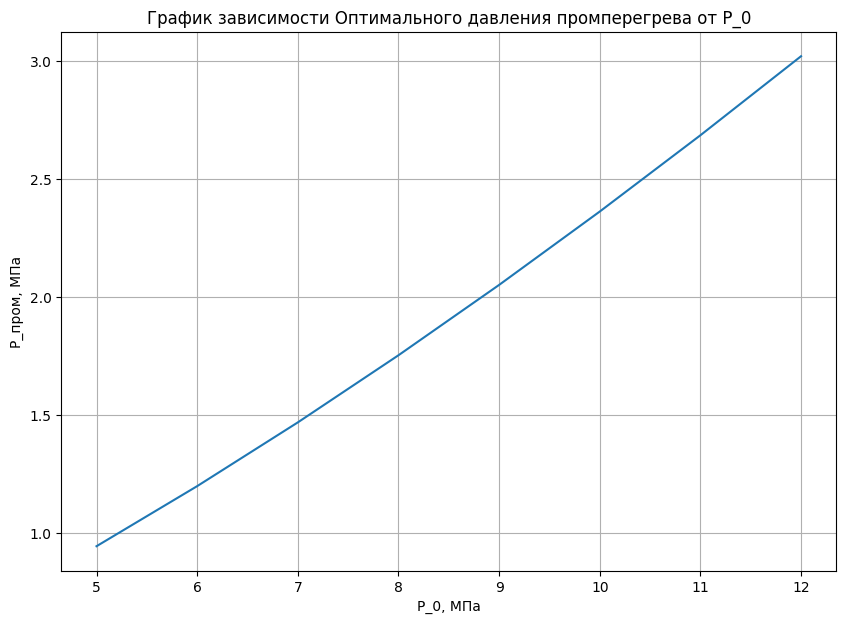

In [11]:
from iapws import IAPWS97 as steam
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

MPa = 10 ** 6
kPa = 10 ** 3
unit = 1 / MPa

def to_kelvin(celsius):
    return celsius + 273.15 if celsius else None

def calculate_states(p_0, p_k, t_0, p_prom, t_prom):
    point_0_start = steam(T=t_0, P=p_0)
    point_0_end = steam(P=p_prom, s=point_0_start.s)
    point_1_start = steam(P=p_prom, T=t_prom)
    point_condenser = steam(P=p_k * unit, s=point_1_start.s)
    point_pump = steam(P=p_k * unit, x=0)
    return point_0_start, point_0_end, point_1_start, point_condenser, point_pump

def calculate_efficiency(point_0_start, point_0_end, point_1_start, point_condenser, point_pump):
    useful_energy = (point_0_start.h - point_0_end.h) + (point_1_start.h - point_condenser.h)
    full_energy = (point_0_start.h - point_pump.h) + (point_1_start.h - point_0_end.h)
    return useful_energy / full_energy

def find_optimal_params(p_0, t_0, p_k):
    def loss_function(middle_params, p_0=p_0, t_0=t_0, p_k=p_k):
        p_div_p_0, t_div_t_0 = middle_params[0], middle_params[1]
        p_prom = p_0 * p_div_p_0
        t_prom = t_0 * t_div_t_0
        point_0_start, point_0_end, point_1_start, point_condenser, point_pump = calculate_states(
            p_0=p_0,
            p_k=p_k,
            t_0=to_kelvin(t_0),
            p_prom=p_prom,
            t_prom=to_kelvin(t_prom)
        )
        efficiency = calculate_efficiency(point_0_start, point_0_end, point_1_start, point_condenser, point_pump)
        return 1 - efficiency

    initial_params = np.array([0.5, 0.5])
    bounds = ((0.01, 1), (0.01, 1))
    result = minimize(loss_function, x0=initial_params, bounds=bounds, tol=1e-8)
    p_div_p_0, t_div_t_0 = result.x
    p_prom = p_div_p_0 * p_0
    t_prom = t_div_t_0 * t_0
    return p_prom, t_prom

fig, graf = plt.subplots(1, 1, figsize=(10, 7))
p_0_values = range(5, 13)
t_0 = 500  # °C
p_k = 5 * kPa
p_prom_values = []

for p_0 in p_0_values:
    p_prom, t_prom = find_optimal_params(p_0, t_0, p_k)
    p_prom_values.append(p_prom)
    print(f"""При p_0 = {p_0} МПа давление промперегрева {round(p_prom, 3)} МПа
Температура промперегрева {t_prom} °C""")
    print(f"--------------------------------------------------------------------")

graf.plot(p_0_values, p_prom_values)
graf.grid()
graf.set_title("График зависимости Оптимального давления промперегрева от P_0")
graf.set_xlabel("P_0, МПа")
graf.set_ylabel("P_пром, МПа")
plt.show()
